In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [11]:
HOME = '/content/drive/MyDrive/Sign_Language'

##Paths

In [14]:
dataset = os.path.join(HOME, 'dataset/keypoint.csv')
model_save_path = os.path.join(HOME, 'models/keypoint_classifier.hdf5')
tflite_save_path = os.path.join(HOME, 'models/keypoint_classifier.tflite')

##Number of Classes

In [5]:
NUM_CLASSES = 3

##Loading the Dataset

In [15]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [16]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

##Making the Model

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1103 (4.31 KB)
Trainable params: 1103 (4.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

##Training

In [22]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.3619 - accuracy: 0.2500
Epoch 1: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
2/2 [==============================] - 1s 271ms/step - loss: 1.3335 - accuracy: 0.2511 - val_loss: 1.2871 - val_accuracy: 0.1067
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.2524 - accuracy: 0.2969
Epoch 2: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
2/2 [==============================] - 0s 81ms/step - loss: 1.2924 - accuracy: 0.2601 - val_loss: 1.2638 - val_accuracy: 0.1067
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.2926 - accuracy: 0.2422
Epoch 3: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 69ms/step - loss: 1.2761 - accuracy: 0.2466 - val_loss: 1.2401 - val_accuracy: 0.1067
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.2055 - accuracy: 0.2891
Epoch 4: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
2/2 [==============================] - 0s 67ms/step - loss: 1.2217 - accuracy: 0.2735 - val_loss: 1.2201 - val_accuracy: 0.1200
Epoch 5/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.2233 - accuracy: 0.2188
Epoch 5: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
2/2 [==============================] - 0s 67ms/step - loss: 1.2099 - accuracy: 0.2646 - val_loss: 1.2035 - val_accuracy: 0.1333
Epoch 6/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.1974 - accuracy: 0.2344
Epoch 6: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
2/2 [==============================] - 0s 89ms/step 

##Evaluation

In [23]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 100ms/step - loss: 0.0712 - accuracy: 0.9600


In [24]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [25]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 136ms/step
[0.00492274 0.95102894 0.04404831]
1


#Confusion Matrix and Classification Report

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

In [28]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

3/3 [==============================] - 0s 5ms/step


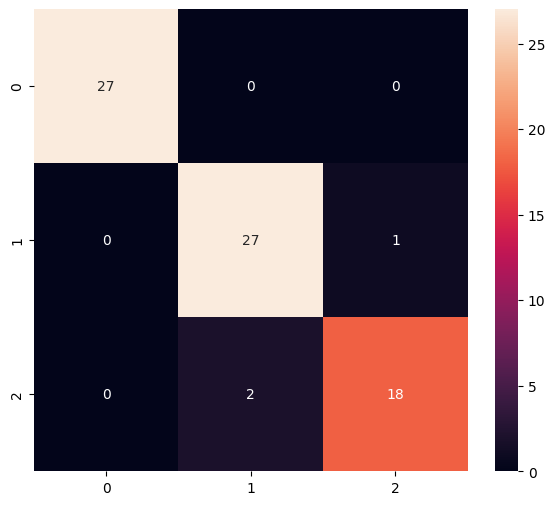

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.93      0.96      0.95        28
           2       0.95      0.90      0.92        20

    accuracy                           0.96        75
   macro avg       0.96      0.95      0.96        75
weighted avg       0.96      0.96      0.96        75



In [29]:
print_confusion_matrix(y_test, y_pred)

##Tensorflow Lite Model (convert)

In [30]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6500

##Testing the converted model

In [32]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [33]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [34]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [35]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.14 ms, sys: 8 µs, total: 1.15 ms
Wall time: 7.31 ms


In [36]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00492274 0.95102894 0.04404832]
1
